
---
title: "Time series with varying intercepts"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

I've done time-series data with time-to-event models and would like to explore modeling with mixed effects models. I'll take an interative approach, in the spirit of [Singer and Willet's Applied Longitudinal Data Analysis: Modeling Change and Event Occurrence](https://academic.oup.com/book/41753?login=false). I discovered this textbook when finding this [post by Nathaniel Forde](https://www.pymc.io/projects/examples/en/latest/time_series/longitudinal_models.html) on the pymc website.

In this post, we'll focus on varying intercepts, first from a Bayesian approach using pymc, followed by an example with statsmodels. In later posts, we'll increase the complexity such as incorporation of varying slopes.


In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [2]:
sns.set_context("talk")
sns.set_palette("colorblind")

In [3]:
def draw_causal_graph(
    edge_list, node_props=None, edge_props=None, graph_direction="UD"
):
    """Utility to draw a causal (directed) graph
    Taken from: https://github.com/dustinstansbury/statistical-rethinking-2023/blob/a0f4f2d15a06b33355cf3065597dcb43ef829991/utils.py#L52-L66

    """
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

# Data generation

In [4]:
# Generate synthetic data
n_patients = 30
n_timepoints = 5

# Create patient IDs
patient_ids = np.repeat(np.arange(n_patients), n_timepoints)

# Create time points
time = np.tile(np.arange(n_timepoints), n_patients)

# Create patient-specific attributes (age and treatment)
age = np.random.randint(40, 70, n_patients)
treatment = np.random.binomial(1, 0.5, n_patients)

# Repeat age and treatment to match the longitudinal measurements
age_repeated = np.repeat(age, n_timepoints)
treatment_repeated = np.repeat(treatment, n_timepoints)

# Combine into a DataFrame
df_data = pd.DataFrame(
    {
        "patient_id": patient_ids,
        "time": time,
        "age": age_repeated,
        "treatment": treatment_repeated,
    }
)

df_data.head(10)

,patient_id,time,age,treatment
0,0,0,66,1
1,0,1,66,1
2,0,2,66,1
3,0,3,66,1
4,0,4,66,1
5,1,0,53,1
6,1,1,53,1
7,1,2,53,1
8,1,3,53,1
9,1,4,53,1


Here's the fun part. We'll simulate the outcome variable tumor size, using some mild assumptions and domain knowledge. First, we'll assume that all participants have been identified as having a solid tumor cancer. Therefore:

- Time is also a positive association risk factor.
- Age is likely a risk factor, so create a positive association between age and tumor size. (Note that we'll keep age as a constant for each patient, such that we're looking at a time window of a few months.)
- Whether one has received treatment should decrease the tumor size, so that will be a negative association.

This will be a simple linear model that we'll use to create data:

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha + \beta_T T_i + \beta_A A_i + \beta_R R_i $$

However, to be clear, we're using this model to *generate* our data but in this post, we'll focus on varying intercepts and ignore predictors time, age, and treatment.

In [5]:
# Use a generative model to create tumor size with some randomness

alpha_tumor_size = 50  # intercept term
bT = 1  # positive association for time
bA = 0.25  # positive association for age
bR = -5  # negative association for treatment

mu_tumor_size = (
    alpha_tumor_size
    + bT * df_data["time"]
    + bA * df_data["age"]
    + bR * df_data["treatment"]
)

sigma_tumor_size = 2

df_data["tumor_size"] = np.random.normal(mu_tumor_size, sigma_tumor_size)

df_data.head()

,patient_id,time,age,treatment,tumor_size
0,0,0,66,1,62.813967
1,0,1,66,1,61.505909
2,0,2,66,1,64.283770
3,0,3,66,1,65.343314
4,0,4,66,1,64.127617


# Data transformation

Before doing any modeling, we'll transform the data since in theory we shouldn't peek. But we can't pick priors unless we have some idea of what the data is like. An easy thing to do is standardize the data and therefore we can use a 0 mean, 2 SD prior to capture most of the data.

In [6]:
df_data["tumor_size_std"] = standardize(df_data["tumor_size"])

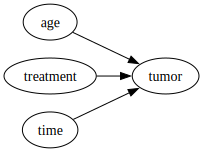

In [7]:
# how to represent patient_specific random effect?
draw_causal_graph(
    edge_list=[("age", "tumor"), ("treatment", "tumor"), ("time", "tumor")],
    graph_direction="LR",
)

In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_id      150 non-null    int64  
 1   time            150 non-null    int64  
 2   age             150 non-null    int64  
 3   treatment       150 non-null    int64  
 4   tumor_size      150 non-null    float64
 5   tumor_size_std  150 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 7.2 KB


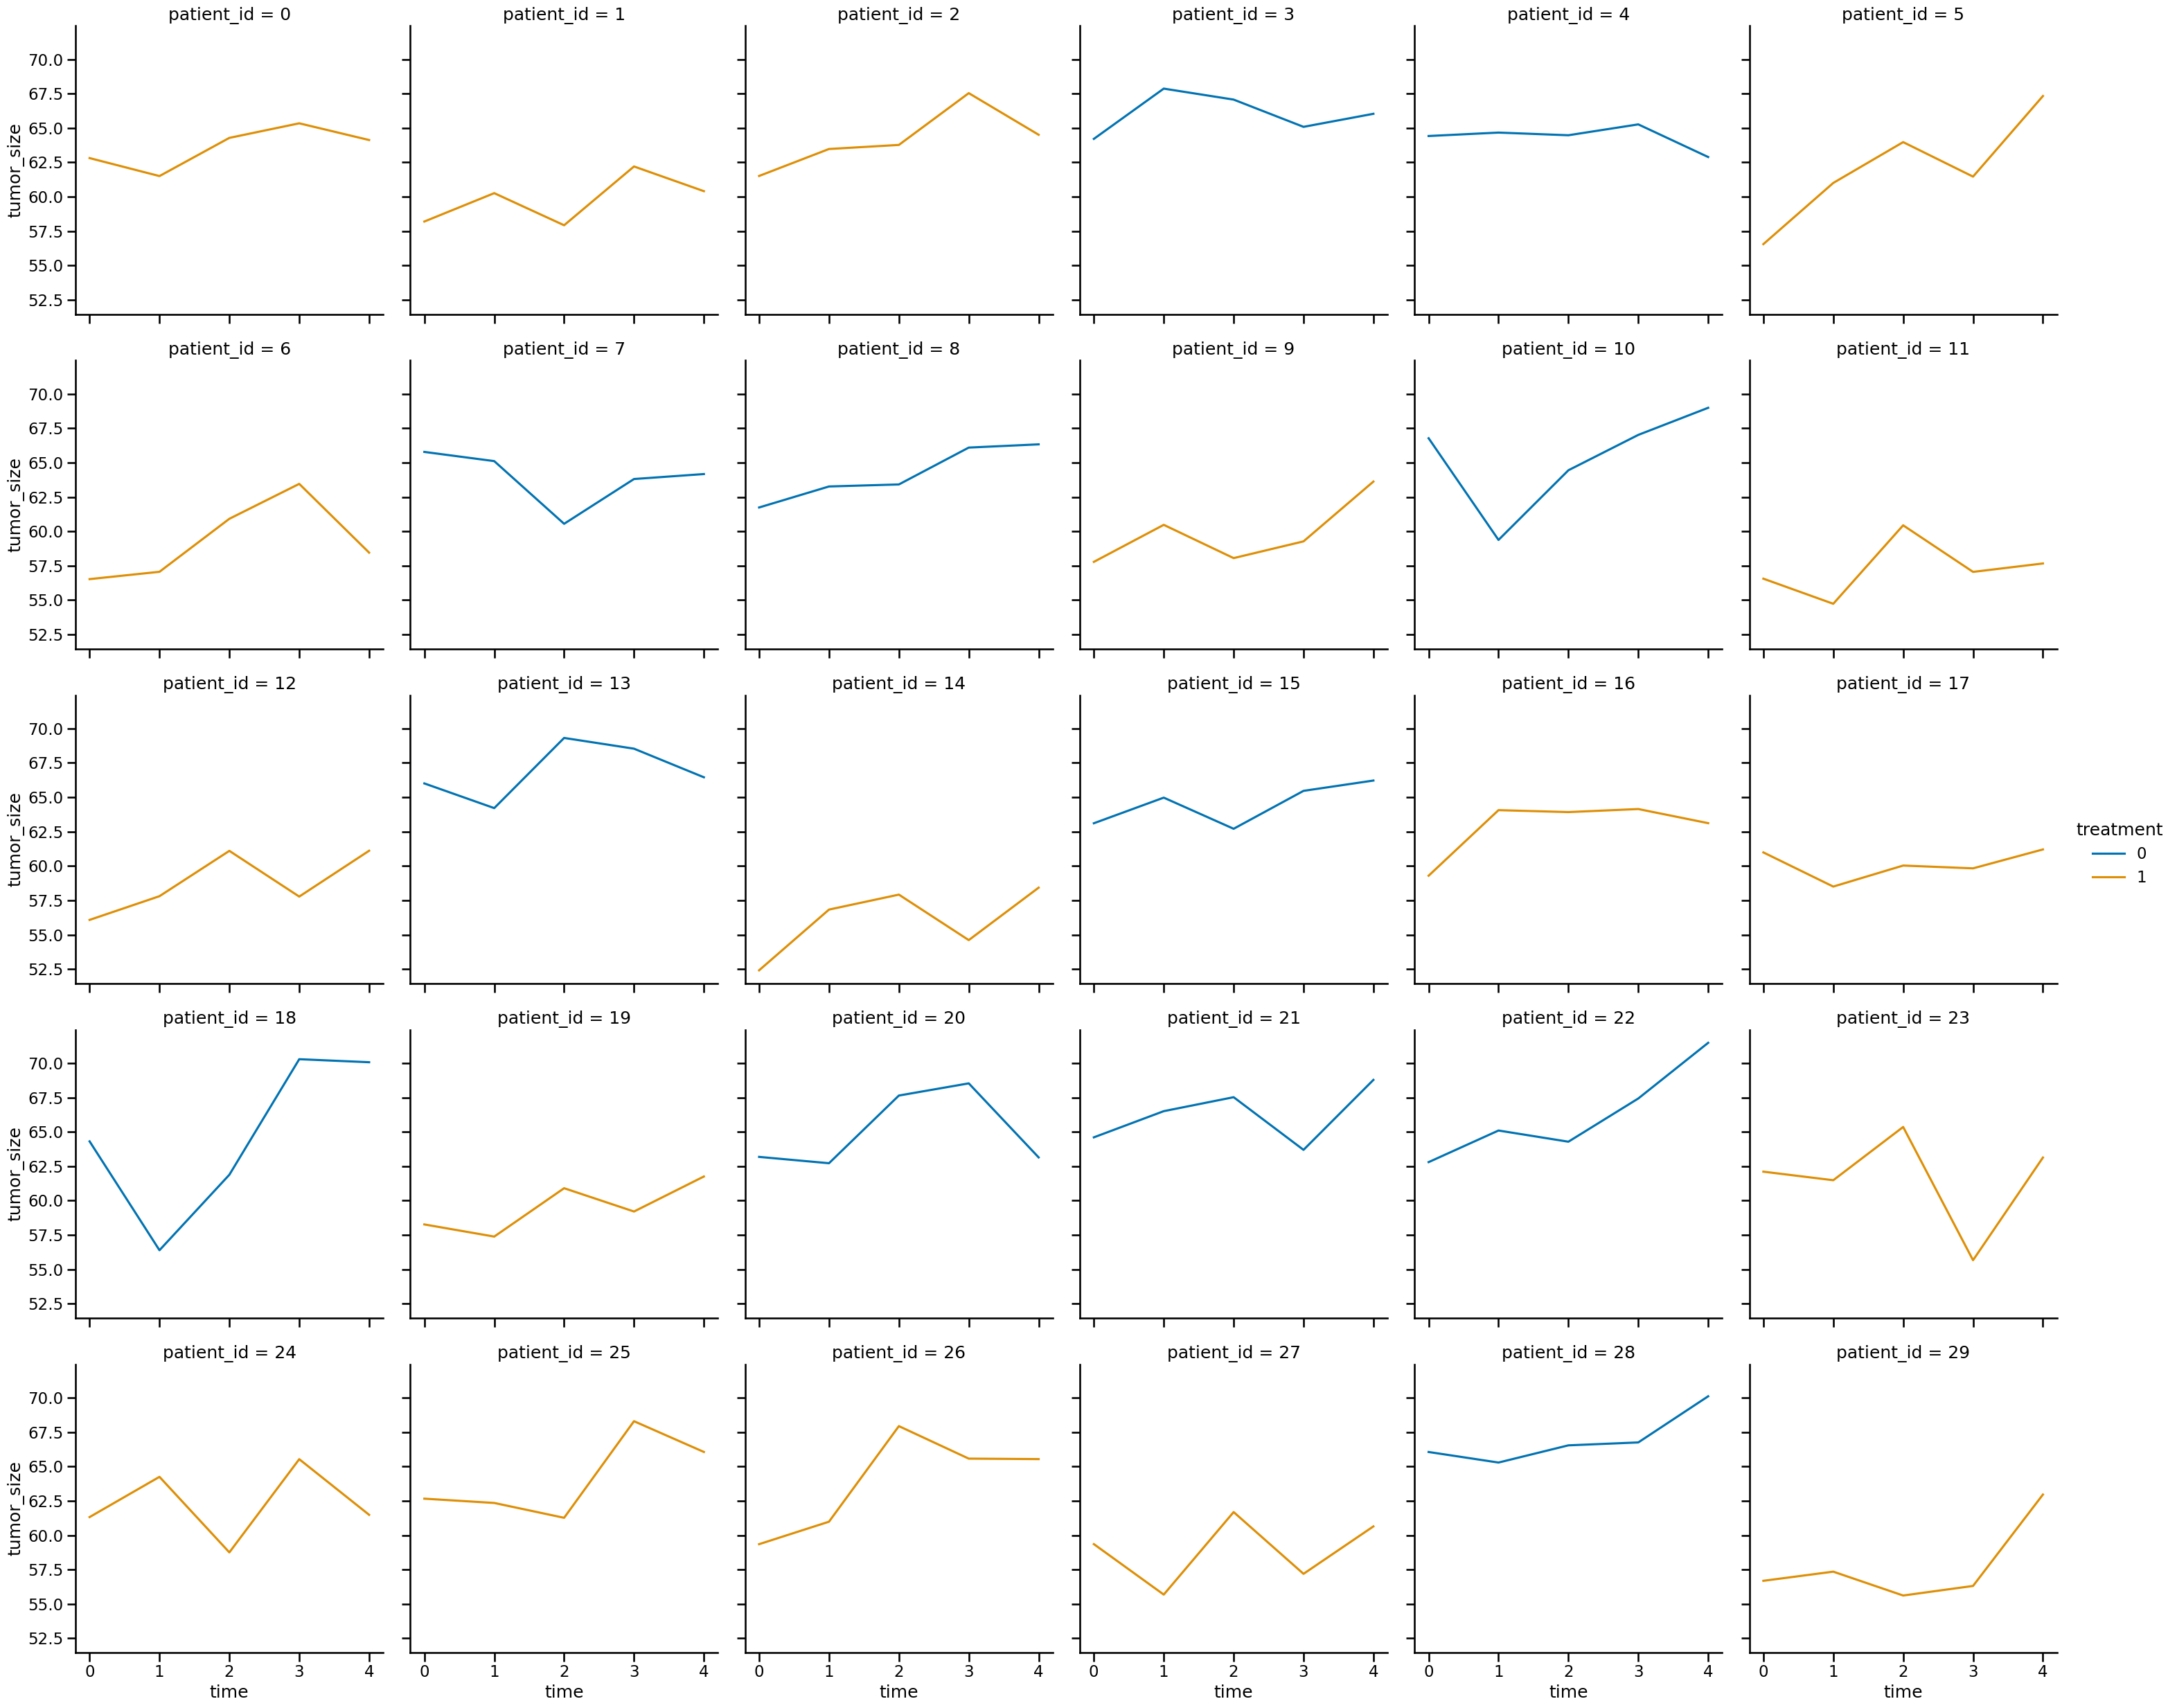

In [9]:
sns.relplot(
    data=df_data,
    x="time",
    y="tumor_size",
    col="patient_id",
    col_wrap=6,
    hue="treatment",
    kind="line",
)

Text(0.5, 1.0, 'Effect of Treatment on tumor size')

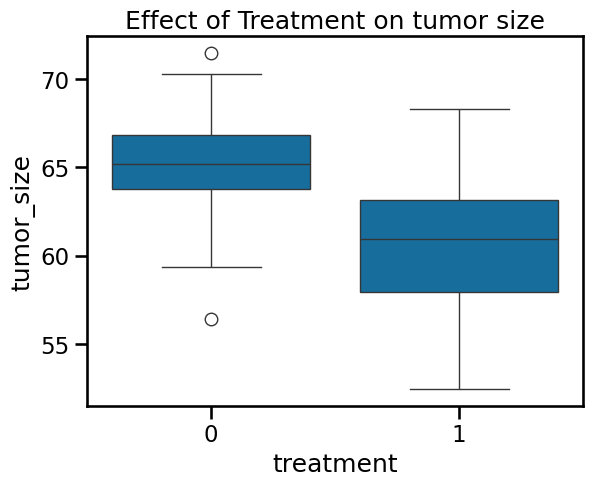

In [10]:
ax = sns.boxplot(
    data=df_data,
    x="treatment",
    y="tumor_size",
)
ax.set_title("Effect of Treatment on tumor size")

# Varying intercepts using pymc

Let's define the equation. We're going to assume the tumor size is Gaussian distributed.

It will be a linear combination of independent variables for time, age, and treatment. How will we represent the `patient_id`? 

There will be a term for average tumor size and the patient-specific tumor size will be the "random effect".

```
s = tumor size
t = time
a = age
r = treatment
```

After reading McElreath, for now, I will ignore time, age, and treatment and just think of patient as a cluster and just do varying intercepts.

$$ \mu_i = \alpha_{\text{pt[i]}} $$


Let's do this step-by-step and work our way from the most naive, simplest models to more complex and informative.

0. **Complete pooling, intercepts only.** Ignore patients as clusters.
1. **No pooling, intercepts only**. Keep intercepts separate for each patient. Ignore information across patients.
2. **Partial pooling, intercepts only.** Share information across patients.

## Model 0: complete pooling

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha  $$

$$ \alpha \sim \text{Normal}(0, 1) $$

$$ \sigma \sim \text{Exponential}(1) $$

The `patient_id` variable is completely ignored. A subscript to denote the patient is not relevant here?

In [11]:
# complete pooling, intercepts only
with pm.Model() as m0:

    # priors
    a = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)

    # linear model
    mu = a

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m0 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━  90% 0:00:02 / 0:00:09

In [12]:
az.summary(trace_m0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.002,0.081,-0.161,0.141,0.001,0.001,4201.0,2889.0,1.0
sigma,1.009,0.059,0.892,1.114,0.001,0.001,4028.0,2539.0,1.0


<Axes: >

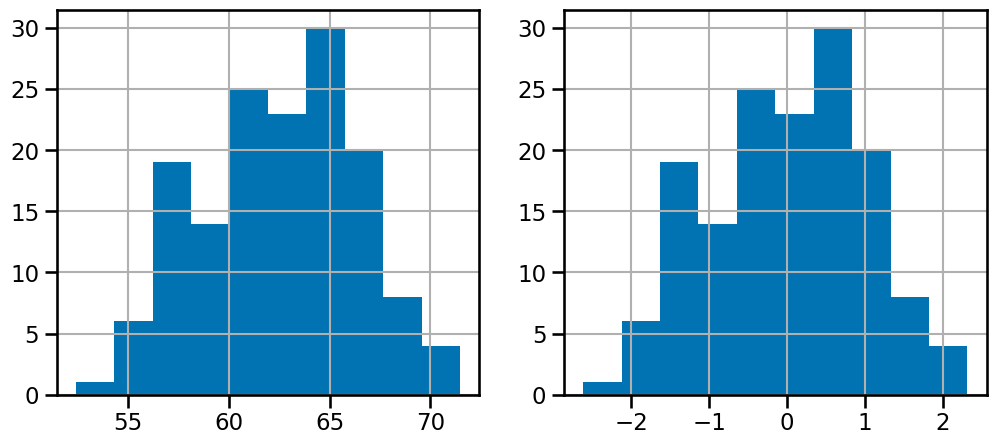

In [13]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))  # do add subplots
df_data["tumor_size"].hist(ax=ax0)
df_data["tumor_size_std"].hist(ax=ax1)

## Model 2: no pooling
Acknowledge that there are patient clusters but do not share any information across them. In other words have a prior but no adaptive regularization.

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha_{\text{pt[i]}}  $$

$$ \alpha_j \sim \text{Normal}(0, 1) $$

$$ \sigma \sim \text{Exponential}(1) $$

In [14]:
# no pooling, intercepts only
with pm.Model() as m1:

    # priors
    a = pm.Normal("a", 0.0, 1, shape=df_data["patient_id"].nunique())
    sigma = pm.Exponential("sigma", 1.0)

    # linear model... # initialize with pymc data?... represent patient as its own cluster
    mu = a[df_data["patient_id"]]

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m1 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━  60% 0:00:05 / 0:00:06

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
az.summary(trace_m1).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.249,0.296,-0.324,0.794,0.003,0.004,7399.0,2915.0,1.0
a[1],-0.644,0.296,-1.198,-0.087,0.003,0.003,8740.0,3331.0,1.0
a[2],0.381,0.300,-0.178,0.942,0.003,0.003,9641.0,2892.0,1.0
a[3],0.831,0.297,0.259,1.383,0.003,0.003,7541.0,2610.0,1.0
a[4],0.426,0.295,-0.128,0.968,0.003,0.003,9279.0,2689.0,1.0


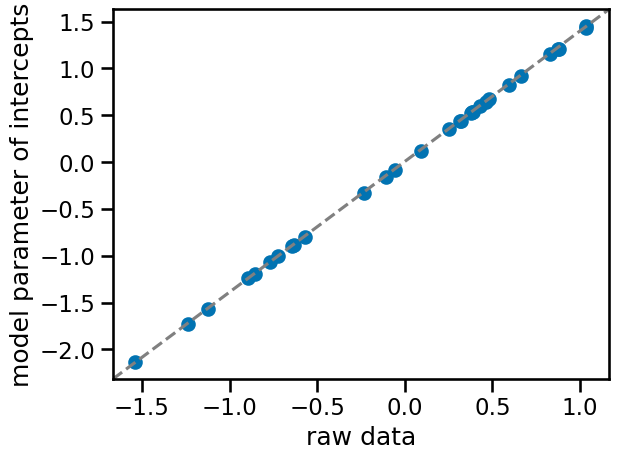

In [16]:
f, ax = plt.subplots()
ax.scatter(
    az.summary(trace_m1, var_names=["a"])["mean"],
    standardize(df_data.groupby("patient_id")["tumor_size"].mean()),
)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="dashed", color="gray")
ax.set(xlabel="raw data", ylabel="model parameter of intercepts");

## Model 2: partial pooling (varying intercepts)

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha_{\text{pt[i]}}  $$

$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\text{pt}}) $$

$$ \bar{\alpha} \sim \text{Normal}(0, 1) $$



$$ \sigma_{\text{pt}} \sim \text{Exponential}(1) $$

$$ \sigma \sim \text{Exponential}(1) $$

**Question**
- can sigma parameter be partially pooled?

In [17]:
# multilevel model, random intercepts
with pm.Model() as m2:

    # prior for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)

    # prior for SD of patients
    sigma_pt = pm.Exponential("sigma_pt", 1.0)

    # alpha priors for each patient
    a = pm.Normal("a", a_bar, sigma_pt, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data["patient_id"]]

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m2 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, sigma_pt, a]


Output()

In [18]:
az.summary(trace_m2, var_names=["a"]).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.236,0.287,-0.290,0.773,0.003,0.004,9775.0,3129.0,1.0
a[1],-0.603,0.293,-1.152,-0.035,0.003,0.003,10061.0,3014.0,1.0
a[2],0.359,0.287,-0.179,0.897,0.003,0.003,7390.0,2768.0,1.0
a[3],0.773,0.288,0.254,1.322,0.003,0.003,8147.0,2850.0,1.0
a[4],0.398,0.292,-0.171,0.928,0.003,0.003,8075.0,2811.0,1.0


In [19]:
az.summary(trace_m2, var_names=["a_bar", "sigma"]).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.003,0.150,-0.286,0.284,0.002,0.002,6844.0,3590.0,1.0
sigma,0.695,0.045,0.611,0.778,0.001,0.000,4631.0,2655.0,1.0


## Comparison of estimates with no pooling, partial pooling


While there isn't an appreciable difference, the multilevel model has a lower standard deviation for each cluster. This is the partial pooling effect.

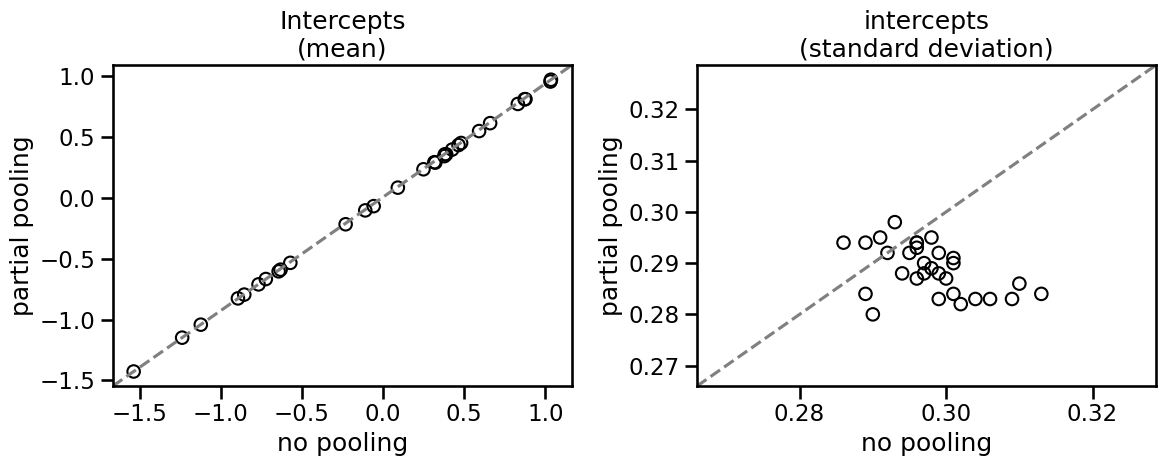

In [20]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# means
ax0.scatter(
    az.summary(trace_m1, var_names=["a"])["mean"],
    az.summary(trace_m2, var_names=["a"])["mean"],
    facecolors="none",
    edgecolors="k",
)
ax0.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
ax0.set(
    xlabel="no pooling",
    ylabel="partial pooling",
    title="Intercepts\n(mean)",
)

# SD
ax1.scatter(
    az.summary(trace_m1, var_names=["a"])["sd"],
    az.summary(trace_m2, var_names=["a"])["sd"],
    facecolors="none",
    edgecolors="k",
)
ax1.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
ax1.set(
    xlabel="no pooling",
    ylabel="partial pooling",
    title="intercepts\n(standard deviation)",
)
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linestyle="dashed", color="gray")

# Calculate the minimum and maximum of both x and y data
data_min = min(
    min(az.summary(trace_m1, var_names=["a"])["sd"]),
    min(az.summary(trace_m2, var_names=["a"])["sd"]),
)
data_max = max(
    max(az.summary(trace_m1, var_names=["a"])["sd"]),
    max(az.summary(trace_m2, var_names=["a"])["sd"]),
)

# Set the limits to be the same for both axes
ax1.set_xlim(data_min * 0.95, data_max * 1.05)
ax1.set_ylim(data_min * 0.95, data_max * 1.05)

f.tight_layout()

You can see that partial pooling decreases the standard error of the intercept parameter in most cases, even though the mean estimate does not really change. Let's see how to implement this in statsmodels.

# Using statsmodels

Using probabilistic programming provides a nice framework to get the random intercepts with probability distributions. But it may not scale as well. Let's explore varying intercepts using statsmodels.

## Varying intercept model

In [26]:
# Define the mixed-effects model formula with only varying intercepts
model = smf.mixedlm("tumor_size_std ~ 1", df_data, groups=df_data["patient_id"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tumor_size_std
No. Observations: 150     Method:             REML          
No. Groups:       30      Scale:              0.4754        
Min. group size:  5       Log-Likelihood:     -186.1971     
Max. group size:  5       Converged:          Yes           
Mean group size:  5.0                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -0.000     0.146  -0.000  1.000  -0.287   0.287
Group Var      0.546     0.272                               



The main thing we want to look at is the bottom of the table. `Intercept` refers to the population's average ($\bar{\alpha}$ while `Group Var` refers to the variance of the random intercepts associated with the grouping variable (`patient_id`) which is `sigma_pt` in the `pymc` model. We can see that these are largely in alignment with the `pymc` results even if `Group Var`/`sigma_pt` differ in their means.

In [54]:
az.summary(trace_m2, var_names=["a_bar", "sigma_pt"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.003,0.150,-0.286,0.284,0.002,0.002,6844.0,3590.0,1.0
sigma_pt,0.759,0.121,0.538,0.981,0.002,0.001,5584.0,3368.0,1.0


# Comparing `pymc` and `statsmodels` output

Now let's see how each individual patient's estimates look between `pymc` and `statsmodels`. Statsmodels doesn't provide the SD directly. It may be derived by bootstrapping but we'll ignore this for now.

In [42]:
# Extract the random effects
df_smf_random_effects = (
    pd.DataFrame(result.random_effects)
    .T.reset_index()
    .rename(columns={"index": "Patient", "Group": "random_effect_mean"})
)

df_smf_random_effects.head()

,Patient,random_effect_mean
0,0,0.237706
1,1,-0.603279
2,2,0.358260
3,3,0.775414
4,4,0.398535


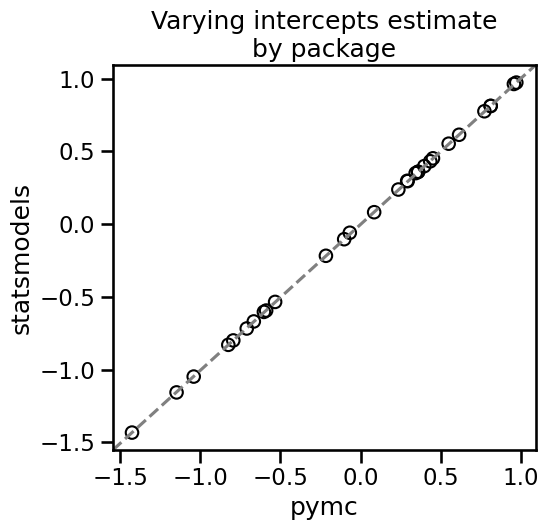

In [55]:
f = plt.figure(figsize=(12, 5))
ax = f.add_subplot(1, 2, 1)

ax.scatter(
    az.summary(trace_m2, var_names=["a"])["mean"],
    df_smf_random_effects['random_effect_mean'],
    facecolors="none",
    edgecolors="k",
)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="dashed", color="gray");
ax.set(
    xlabel="pymc",
    ylabel="statsmodels",
    title="Varying intercepts estimate\nby package",
);

As we can see, the two packages give essentially the same results for varying intercepts.

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue May 28 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

pymc       : 5.15.0
graphviz   : 0.20.3
seaborn    : 0.13.2
matplotlib : 3.8.4
statsmodels: 0.14.2
scipy      : 1.13.0
numpy      : 1.26.4
pandas     : 2.2.2
arviz      : 0.18.0

Watermark: 2.4.3

